# Bartsz Konopka - Laboratorium nr 5 - grupa 2

In [2]:
!pip install scikit-fuzzy

import warnings
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


#warnings.filterwarnings("ignore")

# ZAD 1

Treść:

Proszę zaprojektować rozmyty system sterowania automatycznym podlewaniem grządki. Grządka ma 3m^2, a system podlewania może nawadniać w tempie maksymalnie 25l/dziennie, podczas, gdy zalecana ilość wody dla "zwyczajnych" warunków dla grządki w takim rozmiarze to 10l/dziennie.

System jest sterowany elektronicznie i jest do niego podłączony higrometr (mierzący wilgotność względną w zakresie od 0% do 100%) i termometr. Temperatury są mierzone wyłącznie za dnia i znajdują się w zakresie 15°C - 35°C.Proszę zaprojektować układ rozmytego sterowania, układając reguły na podstawie następującej tabelki:

                Sucho	            Przeciętnie	      Mokro
        Chłodno	Podlewaj średnio	Podlewaj średnio	Podlewaj mało
        Ciepło	 Podlewaj dużo	    Podlewaj średnio	Podlewaj mało
        Gorąco	 Podlewaj dużo	    Podlewaj dużo	    Podlewaj średnio


Proszę samodzielnie zaproponować rozmyte funkcje przynależności i narysować je na wykresach. Proszę przedstawić heatmapę wynikowej funkcji ilości wody używanej dziennie w zależności od wilgotności i temperatury ukrytej w mechanizmie sterowania.

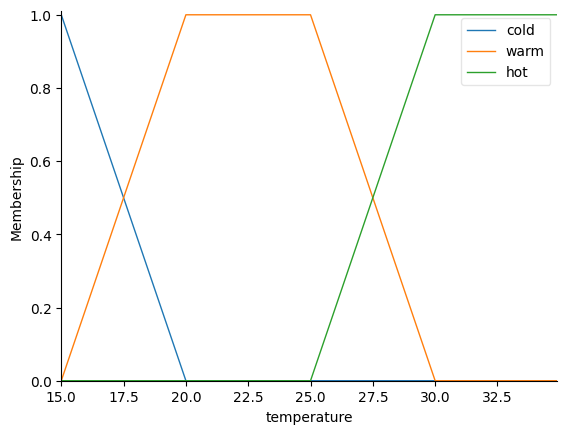

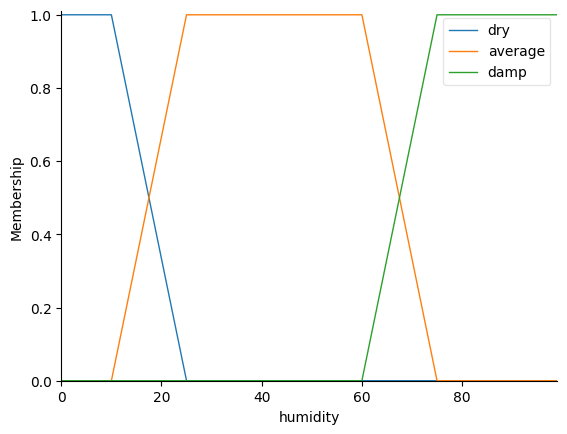

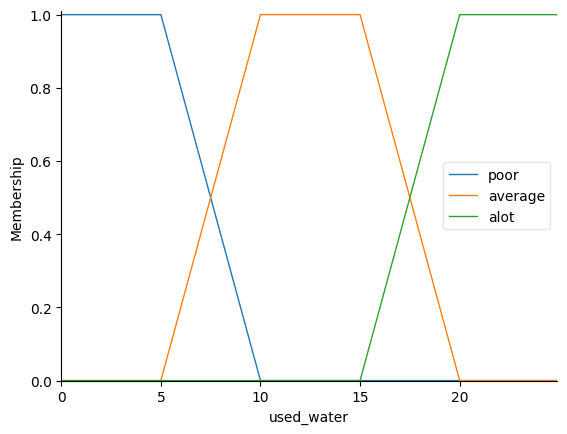

In [3]:
temperature = ctrl.Antecedent(np.arange(15, 35, 0.1),'temperature')

humidity = ctrl.Antecedent(np.arange(0, 100, 1),'humidity')

used_water  = ctrl.Consequent(np.arange(0, 25, 0.1),'used_water')

temperature['cold'] = fuzz.trapmf(temperature.universe, [15, 15, 15, 20])
temperature['warm'] = fuzz.trapmf(temperature.universe, [15, 20, 25, 30])
temperature['hot'] = fuzz.trapmf(temperature.universe, [25, 30, 35, 35])

humidity['dry'] = fuzz.trapmf(humidity.universe, [0, 0, 10, 25])
humidity['average'] = fuzz.trapmf(humidity.universe, [10, 25, 60, 75])
humidity['damp'] = fuzz.trapmf(humidity.universe, [60, 75, 100, 100])

used_water['poor'] = fuzz.trapmf(used_water.universe, [0, 0, 5, 10])
used_water['average'] = fuzz.trapmf(used_water.universe, [5, 10, 15, 20])
used_water['alot'] = fuzz.trapmf(used_water.universe, [15, 20, 25, 25])

temperature.view()
humidity.view()
used_water.view()

In [4]:
rule1 = ctrl.Rule(temperature['cold'] & humidity['dry'], used_water['average'])
rule2 = ctrl.Rule(temperature['cold'] & humidity['average'], used_water['average'])
rule3 = ctrl.Rule(temperature['cold'] & humidity['damp'], used_water['poor'])
rule4 = ctrl.Rule(temperature['warm'] & humidity['dry'], used_water['alot'])
rule5 = ctrl.Rule(temperature['warm'] & humidity['average'], used_water['average'])
rule6 = ctrl.Rule(temperature['warm'] & humidity['damp'], used_water['poor'])
rule7 = ctrl.Rule(temperature['hot'] & humidity['dry'], used_water['alot'])
rule8 = ctrl.Rule(temperature['hot'] & humidity['average'], used_water['alot'])
rule9 = ctrl.Rule(temperature['hot'] & humidity['damp'], used_water['average'])


control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

model = ctrl.ControlSystemSimulation(control_system)

<Axes: xlabel='temperature', ylabel='humidity'>

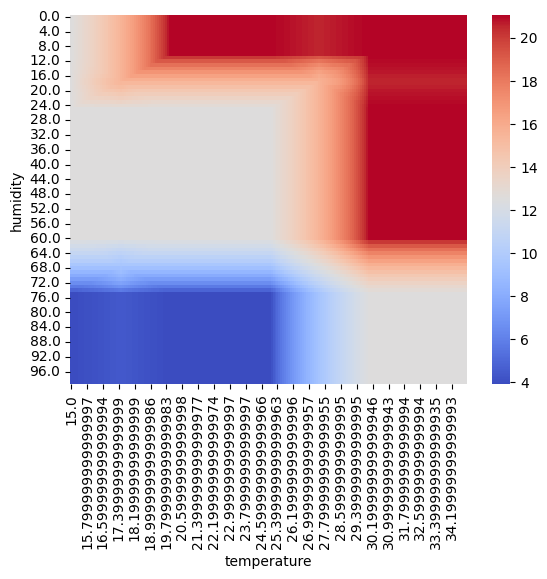

In [5]:
teperature_grid, humidity_grid = np.meshgrid(np.arange(15,35,0.1), np.arange(0, 100, 1))
test_points = np.transpose(np.vstack((np.ravel(teperature_grid),np.ravel(humidity_grid))))

model.input['temperature'] = test_points[:,0]
model.input['humidity'] = test_points[:,1]
model.compute()

test_points = np.concatenate((test_points, model.output['used_water'].reshape(-1,1)), axis=1)

sns.heatmap(pd.DataFrame(test_points, columns = ['temperature','humidity','used_water']).pivot(index='humidity', columns='temperature', values='used_water'), cmap = 'coolwarm')

# ZAD 2

Treść:

Proszę zastanowić się, jaką dodatkową zmienną można wprowadzić do systemu, np. oczekiwany poziom deszczu następnego dnia, wilgotność gleby, nasłonecznienie, siłę wiatru, itp. Problem jest praktyczny, więc proszę zastanowić się przede wszystkim nad takimi zmiennymi, które da się zmierzyć używając elektroniki lub pobrać z jakiegoś internetowego API (np. pogodowego). Proszę ustalić dla tej zmiennej jednostkę, zaproponować jej przynależność do zbiorów rozmytych oraz reguły wnioskowania. Proszę przedstawić co najmniej 4 heatmapy zależności nawadniania od temperatury i wilgotności dla 4 wartości zaproponowanej przez państwa zmiennej. Proszę też podać, jakim czujnikiem lub z jakiego API można pobrać te dane.

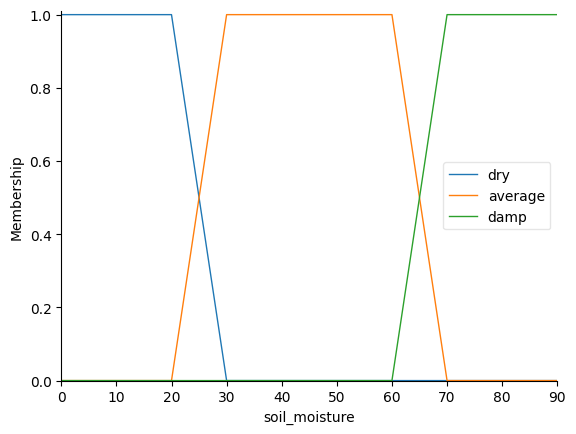

In [6]:
soil_moisture = ctrl.Antecedent(np.arange(0, 100, 10), 'soil_moisture')

soil_moisture['dry'] = fuzz.trapmf(soil_moisture.universe, [0, 0, 20, 30])
soil_moisture['average'] = fuzz.trapmf(soil_moisture.universe, [20, 30, 60, 70])
soil_moisture['damp'] = fuzz.trapmf(soil_moisture.universe, [60, 70, 100, 100])

soil_moisture.view()

In [7]:
rule10 = ctrl.Rule(soil_moisture['dry'], used_water['alot'])
rule11 = ctrl.Rule(soil_moisture['average'], used_water['average'])
rule12 = ctrl.Rule(soil_moisture['damp'], used_water['poor'])

control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12])

model = ctrl.ControlSystemSimulation(control_system)

In [8]:
temperature_grid, humidity_grid, soil_moisture_grid = np.meshgrid(np.arange(15, 35, 0.1), np.arange(0, 100, 1), np.arange(0, 100, 10))
test_points = np.transpose(np.vstack((np.ravel(temperature_grid), np.ravel(humidity_grid), np.ravel(soil_moisture_grid))))

model.input['temperature'] = test_points[:, 0]
model.input['humidity'] = test_points[:, 1]
model.input['soil_moisture'] = test_points[:, 2]
model.compute()

test_points = np.concatenate((test_points, model.output['used_water'].reshape(-1,1)), axis=1)


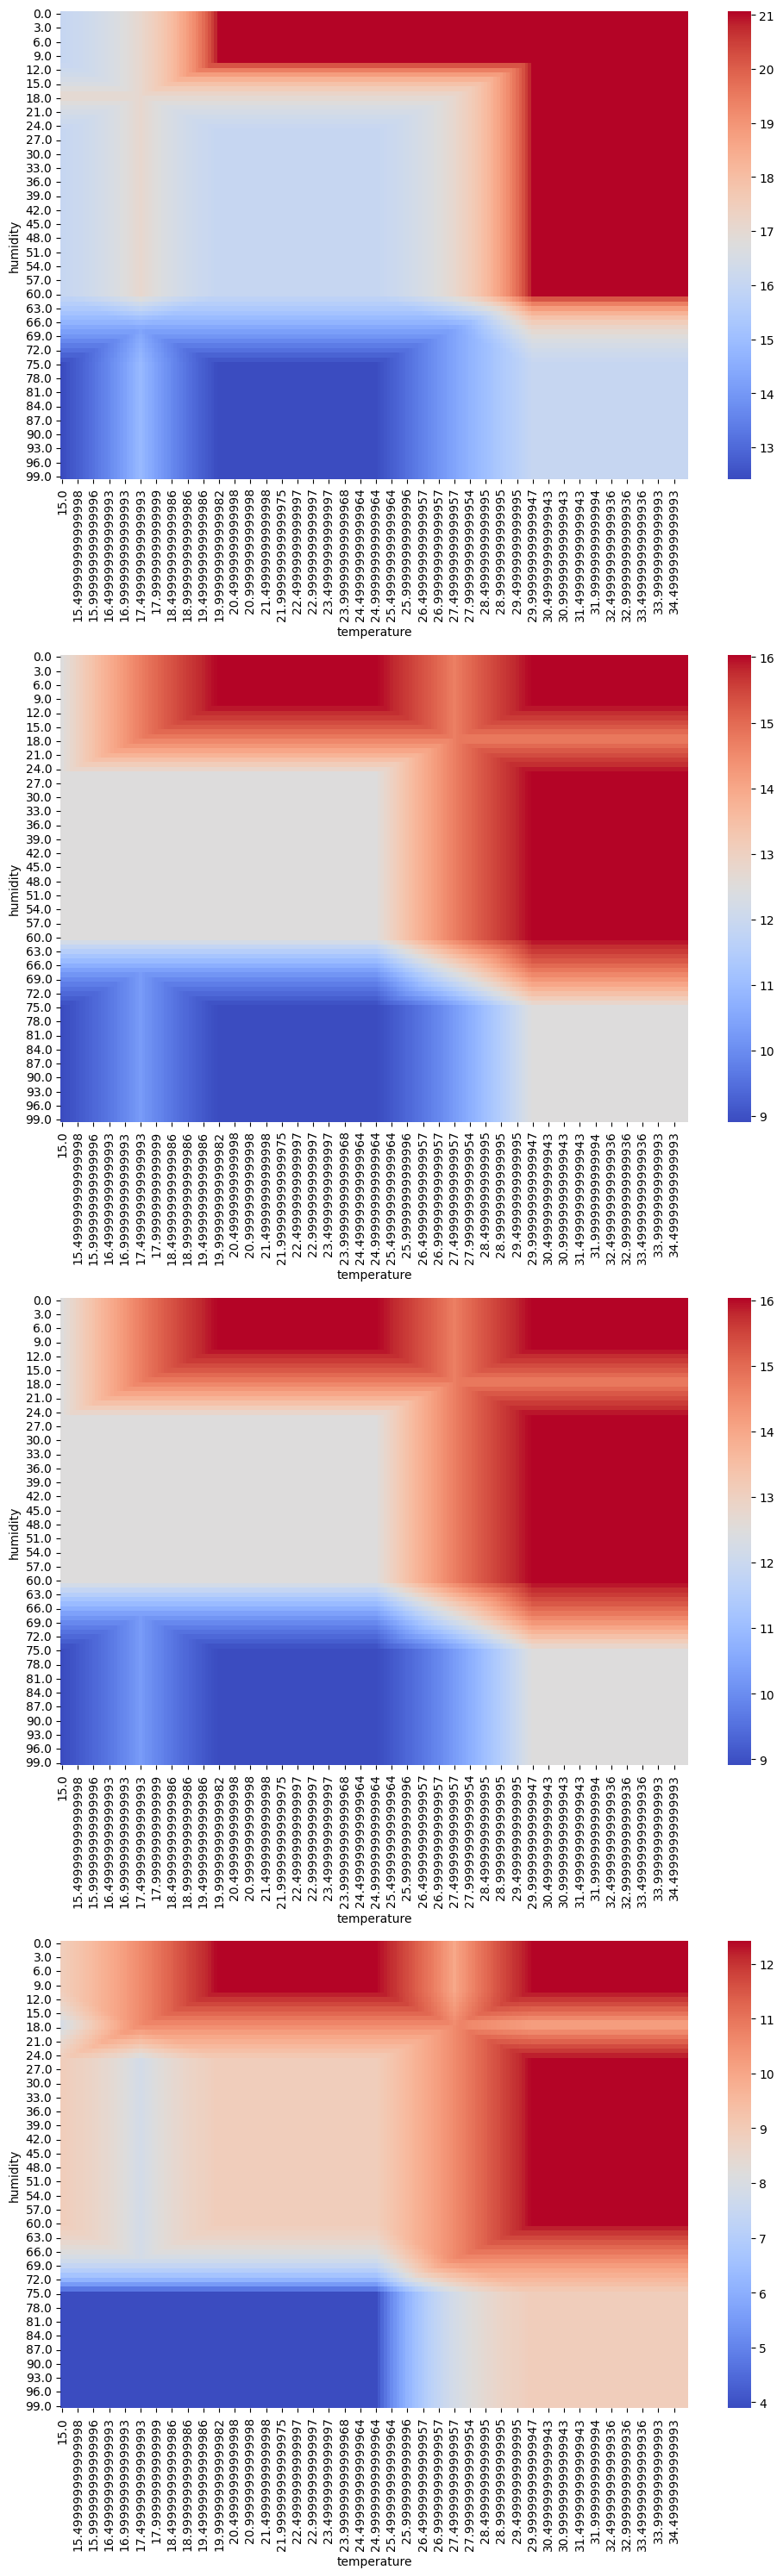

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(10, 30))

sns.heatmap(pd.DataFrame(test_points[test_points[:, 2] == 10, :], columns=['temperature', 'humidity', 'soil_moisture', 'used_water']).pivot(index='humidity', columns='temperature', values='used_water'), cmap='coolwarm', ax=axs[0])
sns.heatmap(pd.DataFrame(test_points[test_points[:, 2] == 30, :], columns=['temperature', 'humidity', 'soil_moisture', 'used_water']).pivot(index='humidity', columns='temperature', values='used_water'), cmap='coolwarm', ax=axs[1])
sns.heatmap(pd.DataFrame(test_points[test_points[:, 2] == 50, :], columns=['temperature', 'humidity', 'soil_moisture', 'used_water']).pivot(index='humidity', columns='temperature', values='used_water'), cmap='coolwarm', ax=axs[2])
sns.heatmap(pd.DataFrame(test_points[test_points[:, 2] == 70, :], columns=['temperature', 'humidity', 'soil_moisture', 'used_water']).pivot(index='humidity', columns='temperature', values='used_water'), cmap='coolwarm', ax=axs[3])

plt.tight_layout()
plt.show()

# ZAD 3

Treść:

Proszę zaproponować rozmyty system wnioskowania dla dowolnego wybranego (ale różnego od poruszanych dotychczas) problemu. Proszę wziąć pod uwagę co najmniej trzy zmienne wejściowe i każdą zmienną podzielić na co najmniej trzy zbiory rozmyte. Proszę stworzyć co najmniej 5 reguł i skomentować wyniki.

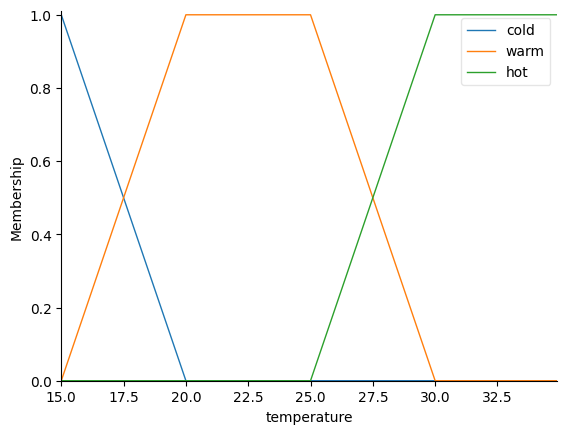

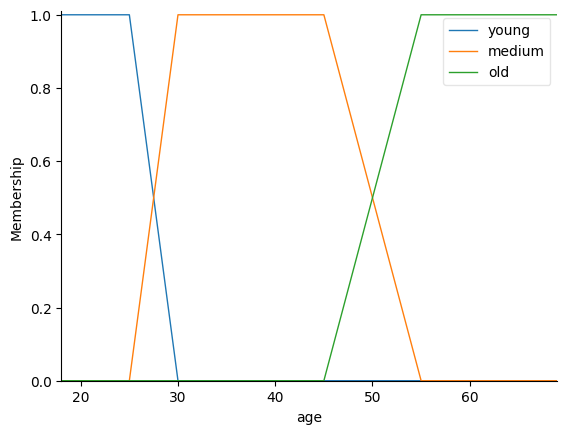

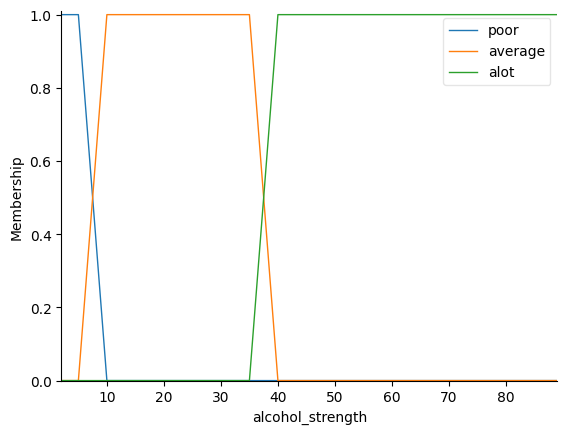

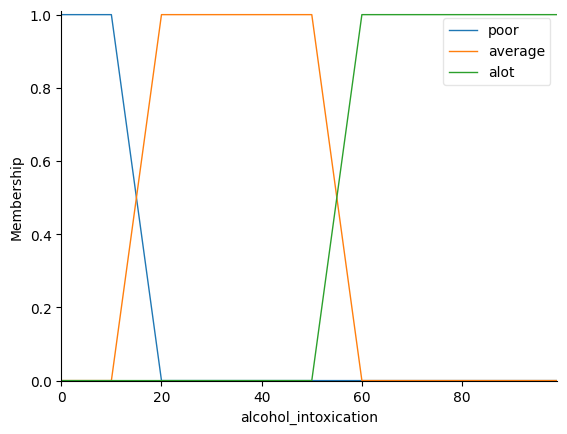

In [12]:
#temperatura
temperature = ctrl.Antecedent(np.arange(15, 35, 0.1),'temperature')

#wiek
age = ctrl.Antecedent(np.arange(18, 70, 1),'age')

#moc alkoholu
alcohol_strength  = ctrl.Antecedent(np.arange(2, 90, 1),'alcohol_strength')

#stan upojenia alkoholowego
alcohol_intoxication = ctrl.Consequent(np.arange(0, 100, 1),'alcohol_intoxication')

temperature['cold'] = fuzz.trapmf(temperature.universe, [15, 15, 15, 20])
temperature['warm'] = fuzz.trapmf(temperature.universe, [15, 20, 25, 30])
temperature['hot'] = fuzz.trapmf(temperature.universe, [25, 30, 35, 35])

age['young'] = fuzz.trapmf(age.universe, [18, 18, 25, 30])
age['medium'] = fuzz.trapmf(age.universe, [25, 30, 45, 55])
age['old'] = fuzz.trapmf(age.universe, [45, 55, 70, 70])

alcohol_strength['poor'] = fuzz.trapmf(alcohol_strength.universe, [2, 2, 5, 10])
alcohol_strength['average'] = fuzz.trapmf(alcohol_strength.universe, [5, 10, 35, 40])
alcohol_strength['alot'] = fuzz.trapmf(alcohol_strength.universe, [35, 40, 90, 90])

alcohol_intoxication['poor'] = fuzz.trapmf(alcohol_intoxication.universe, [0, 0, 10, 20])
alcohol_intoxication['average'] = fuzz.trapmf(alcohol_intoxication.universe, [10, 20, 50, 60])
alcohol_intoxication['alot'] = fuzz.trapmf(alcohol_intoxication.universe, [50, 60, 100, 100])

temperature.view()
age.view()
alcohol_strength.view()
alcohol_intoxication.view()

In [15]:
rule1 = ctrl.Rule(age['young'] & alcohol_strength['poor'], alcohol_intoxication['average'])
rule2 = ctrl.Rule(age['young'] & alcohol_strength['average'], alcohol_intoxication['alot'])
rule3 = ctrl.Rule(age['young'] & alcohol_strength['alot'], alcohol_intoxication['alot'])
rule4 = ctrl.Rule(age['medium'] & alcohol_strength['poor'], alcohol_intoxication['poor'])
rule5 = ctrl.Rule(age['medium'] & alcohol_strength['average'], alcohol_intoxication['average'])
rule6 = ctrl.Rule(age['medium'] & alcohol_strength['alot'], alcohol_intoxication['alot'])
rule7 = ctrl.Rule(age['old'] & alcohol_strength['poor'], alcohol_intoxication['poor'])
rule8 = ctrl.Rule(age['old'] & alcohol_strength['average'], alcohol_intoxication['average'])
rule9 = ctrl.Rule(age['old'] & alcohol_strength['alot'], alcohol_intoxication['alot'])
rule10 = ctrl.Rule(temperature['hot'], alcohol_intoxication['alot'])
rule11 = ctrl.Rule(temperature['warm'], alcohol_intoxication['average'])
rule12 = ctrl.Rule(temperature['cold'], alcohol_intoxication['poor'])

control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12])

model = ctrl.ControlSystemSimulation(control_system)

In [33]:
age_grid, alcohol_strength_grid, temperature = np.meshgrid( np.arange(18, 70, 1), np.arange(2, 90, 1), np.arange(15, 35, 0.1))
test_points = np.transpose(np.vstack((np.ravel(age_grid), np.ravel(alcohol_strength_grid), np.ravel(temperature_grid))))

model.input['age'] = test_points[:, 0]
model.input['alcohol_strength'] = test_points[:, 1]
model.input['temperature'] = test_points[:, 2]
model.compute()

test_points = np.concatenate((test_points, model.output['alcohol_intoxication'].reshape(-1,1)), axis=1)

<Axes: xlabel='age', ylabel='alcohol_strength'>

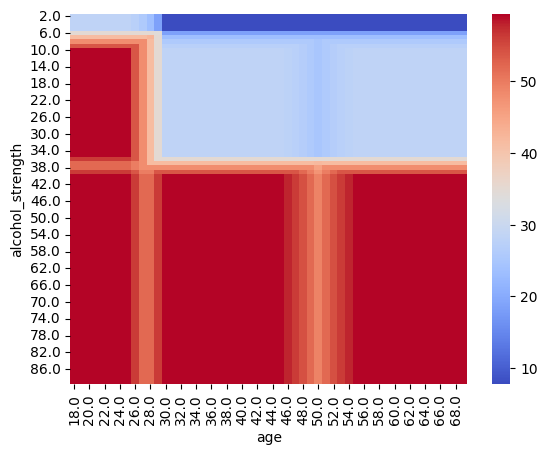

In [36]:
sns.heatmap(pd.DataFrame(test_points[test_points[:, 2] == 15.0, :], columns=['age', 'alcohol_strength', 'temperature', 'alcohol_intoxication']).pivot(index='alcohol_strength', columns='age', values='alcohol_intoxication'), cmap='coolwarm')